In [13]:
import torch
import torch.nn as nn
import torch.nn.parallel
from torchvision.models import mnasnet0_5, MNASNet0_5_Weights
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
import seaborn as sns
from sklearn import metrics
import time
import copy
import os

In [14]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)
# torch.backends controls the behavior of various backends that PyTorch supports.
# A bool that, if True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.
torch.backends.cudnn.benchmark = False

# A bool that, if True, causes cuDNN to only use deterministic convolution algorithms.
torch.backends.cudnn.deterministic = True

In [15]:
SAVE_PATH = './mobilenet.pt'
BATCH_SIZE = 256 #@param number

In [17]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(232),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
data_dir = './data'
image_datasets = {
  x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']
}
dataloaders = {
  x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=16) for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data.
      print(f"Phase: {phase}")
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)
      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [28]:
#Load in a pre-trained model: efficient net
model = mnasnet0_5(weights=MNASNet0_5_Weights.DEFAULT)

# freeze all parameters of the model
for param in model.parameters():
  param.requires_grad = False

model.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=True), nn.Linear(1280, 27))
# model.load_state_dict(torch.load('./mobilenet.pt.pt')['model_state_dict'])
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [29]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
Phase: train


100%|██████████| 95/95 [00:14<00:00,  6.43it/s]


train Loss: 1.9627 Acc: 0.5617
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.58it/s]


val Loss: 1.7943 Acc: 0.4981

Epoch 1/19
----------
Phase: train


100%|██████████| 95/95 [00:14<00:00,  6.66it/s]


train Loss: 1.1969 Acc: 0.7149
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.59it/s]


val Loss: 1.5951 Acc: 0.5363

Epoch 2/19
----------
Phase: train


100%|██████████| 95/95 [00:14<00:00,  6.68it/s]


train Loss: 1.0324 Acc: 0.7430
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


val Loss: 1.4593 Acc: 0.5667

Epoch 3/19
----------
Phase: train


100%|██████████| 95/95 [00:14<00:00,  6.57it/s]


train Loss: 0.9481 Acc: 0.7565
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.32it/s]


val Loss: 1.2980 Acc: 0.6148

Epoch 4/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.07it/s]


train Loss: 0.9092 Acc: 0.7617
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


val Loss: 1.2823 Acc: 0.6281

Epoch 5/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.02it/s]


train Loss: 0.8779 Acc: 0.7653
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.40it/s]


val Loss: 1.2451 Acc: 0.6278

Epoch 6/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.04it/s]


train Loss: 0.8543 Acc: 0.7740
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.39it/s]


val Loss: 1.1871 Acc: 0.6426

Epoch 7/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.08it/s]


train Loss: 0.8463 Acc: 0.7723
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.52it/s]


val Loss: 1.1230 Acc: 0.6696

Epoch 8/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.31it/s]


train Loss: 0.8151 Acc: 0.7828
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


val Loss: 1.1060 Acc: 0.6774

Epoch 9/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.33it/s]


train Loss: 0.8081 Acc: 0.7835
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.57it/s]


val Loss: 1.0636 Acc: 0.6874

Epoch 10/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.14it/s]


train Loss: 0.7993 Acc: 0.7840
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.43it/s]


val Loss: 1.0307 Acc: 0.6952

Epoch 11/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.12it/s]


train Loss: 0.7972 Acc: 0.7840
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.35it/s]


val Loss: 1.0285 Acc: 0.6978

Epoch 12/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.24it/s]


train Loss: 0.7938 Acc: 0.7834
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.37it/s]


val Loss: 0.9783 Acc: 0.7115

Epoch 13/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.20it/s]


train Loss: 0.7772 Acc: 0.7906
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.41it/s]


val Loss: 0.9423 Acc: 0.7278

Epoch 14/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.19it/s]


train Loss: 0.7811 Acc: 0.7853
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.40it/s]


val Loss: 0.9496 Acc: 0.7204

Epoch 15/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.19it/s]


train Loss: 0.7760 Acc: 0.7867
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


val Loss: 0.8916 Acc: 0.7415

Epoch 16/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.20it/s]


train Loss: 0.7698 Acc: 0.7905
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.37it/s]


val Loss: 0.8940 Acc: 0.7407

Epoch 17/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.22it/s]


train Loss: 0.7663 Acc: 0.7901
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.36it/s]


val Loss: 0.8775 Acc: 0.7430

Epoch 18/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.08it/s]


train Loss: 0.7570 Acc: 0.7915
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.33it/s]


val Loss: 0.8291 Acc: 0.7600

Epoch 19/19
----------
Phase: train


100%|██████████| 95/95 [00:15<00:00,  6.07it/s]


train Loss: 0.7792 Acc: 0.7883
Phase: val


100%|██████████| 11/11 [00:03<00:00,  3.41it/s]

val Loss: 0.8212 Acc: 0.7574

Training complete in 6m 10s
Best val Acc: 0.760000


tensor(2.6400, device='cuda:0') tensor(-2.1179, device='cuda:0')


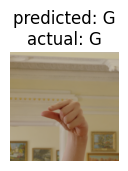

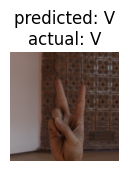

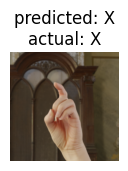

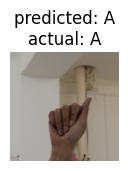

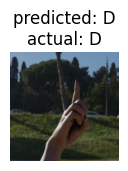

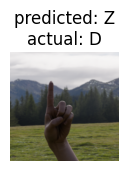

In [36]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp[0] = ((inp[0] * 0.229) + 0.485)
    inp[1] = ((inp[1] * 0.224) + 0.456)
    inp[2] = ((inp[2] * 0.225) + 0.406)
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    class_names = list(image_datasets['val'].find_classes('./data/val')[1].keys())

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            print(inputs.max(), inputs.min())

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\nactual: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)

In [8]:
# Checkpoint
torch.save({
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict()
}, f'{SAVE_PATH}.pt')

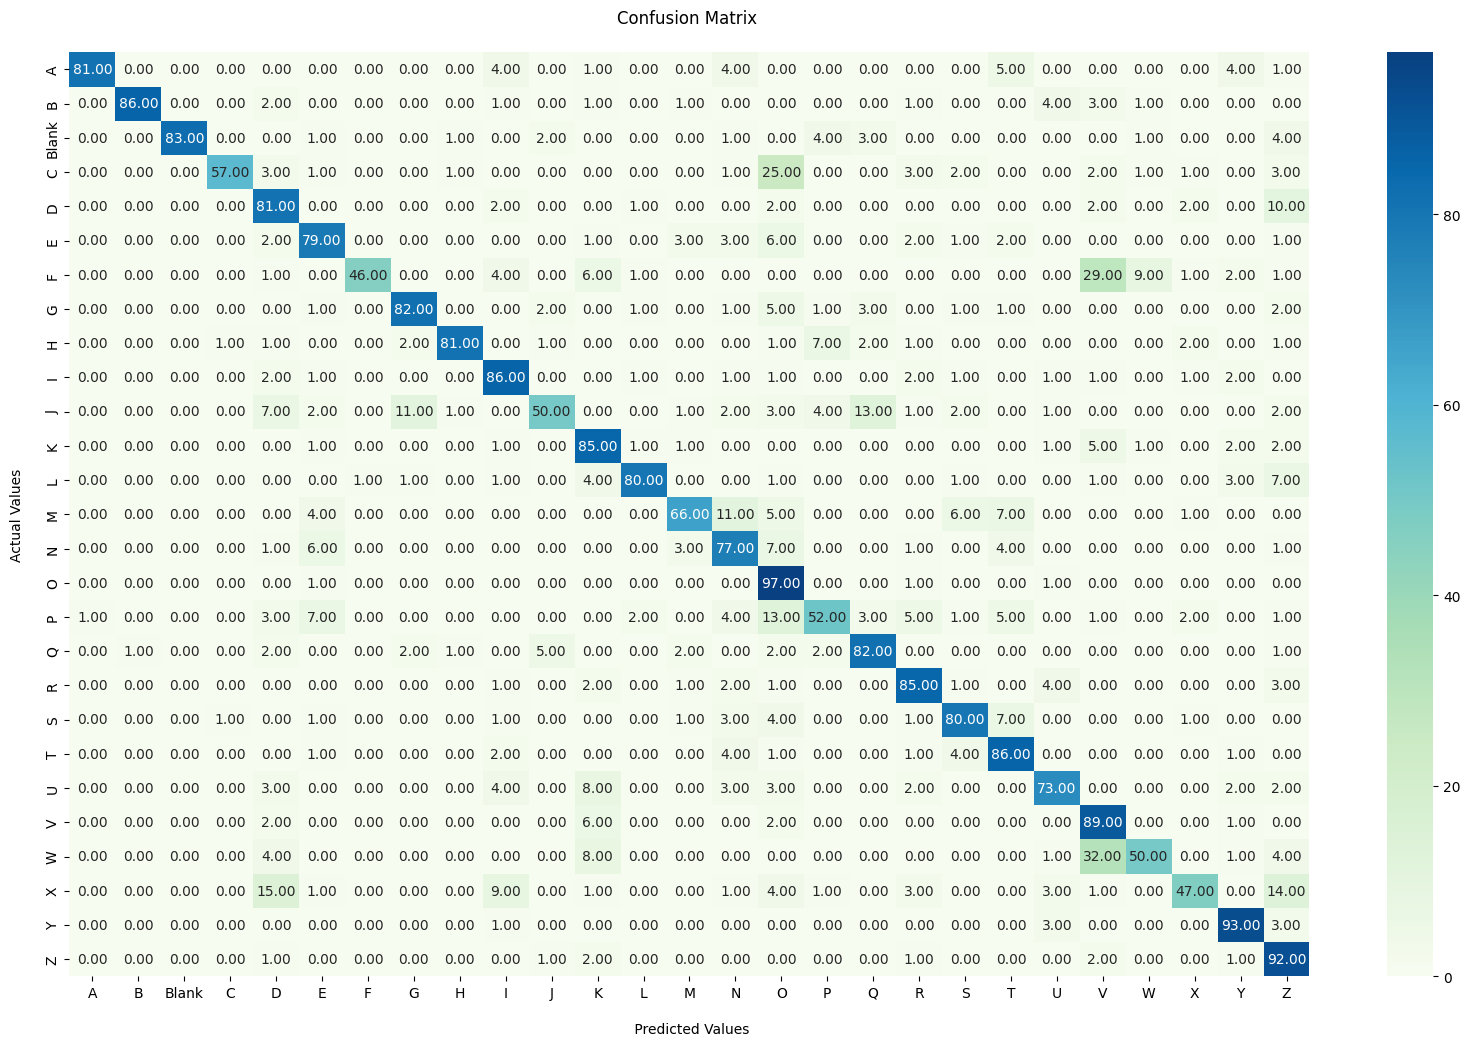

In [23]:
def conf_matrix(model):
  was_training = model.training
  model.eval()
  class_names = list(image_datasets['val'].find_classes('./data/val')[1].keys())

  all_pred = np.empty(0)
  all_labels = np.empty(0)
  with torch.no_grad():
    for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      all_pred = np.concatenate((all_pred, preds.cpu().numpy()))
      all_labels = np.concatenate((all_labels, labels.cpu().numpy()))

  plt.figure(figsize=(20,12))
  fx=sns.heatmap(metrics.confusion_matrix(all_labels,all_pred), annot=True, fmt=".2f",cmap="GnBu")
  fx.set_title('Confusion Matrix \n')
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n')
  fx.xaxis.set_ticklabels(class_names)
  fx.yaxis.set_ticklabels(class_names)
  plt.show()

  model.train(mode=was_training)

conf_matrix(model)

In [ ]:
inputs, classes = next(iter(dataloaders['test']))
print(inputs.shape, classes.shape)

In [24]:
model.cpu()
model.eval()
with torch.no_grad():
  inputs, classes = next(iter(dataloaders['val']))
  input = inputs[0,:,:,:].unsqueeze(0)

  print(inputs.shape, classes.shape)
  torch.onnx.export(model,
                    input,
                    'trained_model.onnx',
                    export_params=True,
                    input_names=['input'],
                    output_names=['output'],
                    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                  'output' : {0 : 'batch_size'}}
                    )

torch.Size([256, 3, 224, 224]) torch.Size([256])
============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



  9%|▉         | 1/11 [00:02<00:27,  2.78s/it]

(256,) (0,)


 18%|█▊        | 2/11 [00:03<00:11,  1.29s/it]

(256,) (256,)


 27%|██▋       | 3/11 [00:03<00:06,  1.23it/s]

(256,) (512,)


 36%|███▋      | 4/11 [00:03<00:04,  1.70it/s]

(256,) (768,)


 45%|████▌     | 5/11 [00:03<00:02,  2.16it/s]

(256,) (1024,)


 55%|█████▍    | 6/11 [00:03<00:01,  2.58it/s]

(256,) (1280,)


 64%|██████▎   | 7/11 [00:04<00:01,  2.95it/s]

(256,) (1536,)


 73%|███████▎  | 8/11 [00:04<00:00,  3.26it/s]

(256,) (1792,)


 82%|████████▏ | 9/11 [00:04<00:00,  3.49it/s]

(256,) (2048,)


100%|██████████| 11/11 [00:05<00:00,  4.44it/s]

(256,) (2304,)
(140,) (2560,)


100%|██████████| 11/11 [00:05<00:00,  2.13it/s]


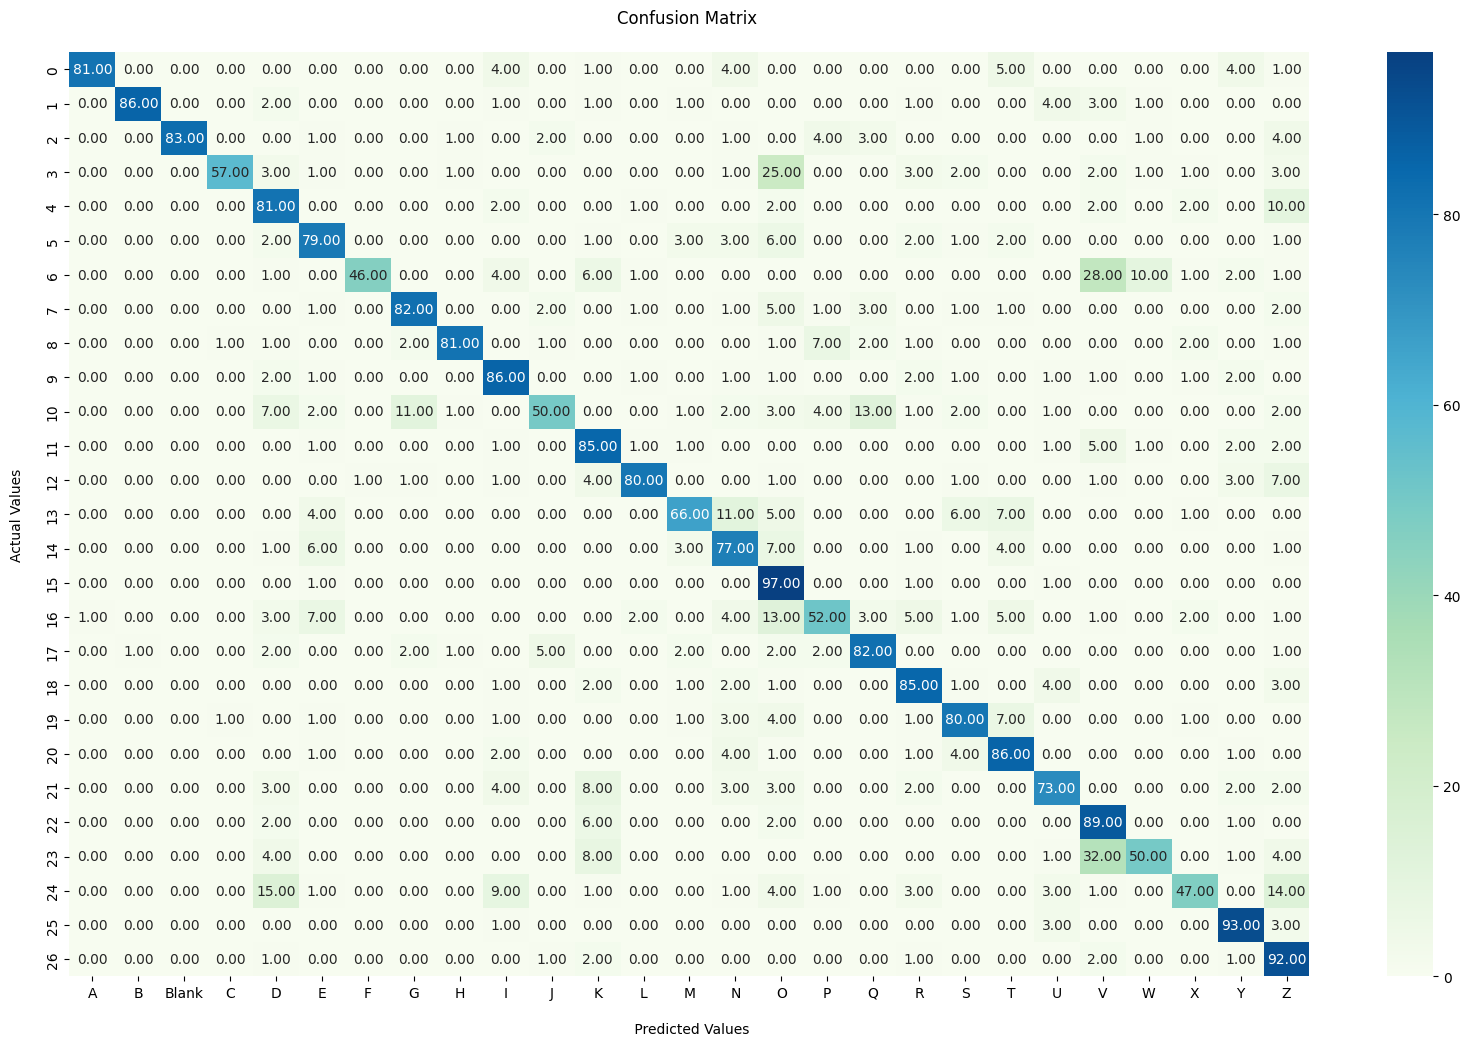

In [25]:
import onnx
import onnxruntime as ort

# Load the ONNX model
onnx_model = onnx.load("trained_model.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)


def conf_matrix_onnx():
  ort_sess = ort.InferenceSession('trained_model.onnx')

  class_names = list(image_datasets['val'].find_classes('./data/val')[1].keys())

  all_pred = np.empty(0)
  all_labels = np.empty(0)
  for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.cpu().numpy()
    labels = labels.cpu().numpy()

    outputs = ort_sess.run(None, {'input': inputs})
    preds = np.argmax(outputs[0], 1)

    print(preds.shape, all_pred.shape)

    all_pred = np.concatenate((all_pred, preds))
    all_labels = np.concatenate((all_labels, labels))

  plt.figure(figsize=(20,12))
  fx=sns.heatmap(metrics.confusion_matrix(all_labels,all_pred), annot=True, fmt=".2f",cmap="GnBu")
  fx.set_title('Confusion Matrix \n')
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n')
  fx.xaxis.set_ticklabels(class_names)
  plt.show()

conf_matrix_onnx()

In [22]:
list(image_datasets['val'].find_classes('./data/val')[1].keys())

['A',
 'B',
 'Blank',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']